<a href="https://colab.research.google.com/github/shimo8810/machine_intelligence/blob/master/deep_learning/colab/SRResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SRResNet(Single Image Super-resolution)


In [1]:
!curl https://colab.chainer.org/install | sh -
!pip install -q chainercv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1379  100  1379    0     0   5560      0 --:--:-- --:--:-- --:--:--  5560
+ apt -y -q install cuda-libraries-dev-9-2
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-9-2 is already the newest version (9.2.148-1).
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.
+ pip install -q cupy-cuda92  chainer 
+ set +ex
Installation succeeded!


In [0]:
from pathlib import Path
from PIL import Image
from chainercv import transforms
import cupy as cp
from tqdm import tqdm

from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.dataset import dataset_mixin
from chainer import training
from chainer.training import extensions

## Load Data from Google Drive

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip -qq -n 'gdrive/My Drive/Data/DIV2K/DIV2K_valid_HR.zip'
!unzip -qq -n 'gdrive/My Drive/Data/DIV2K/DIV2K_valid_LR_bicubic_X4.zip'
!unzip -qq -n 'gdrive/My Drive/Data/DIV2K/DIV2K_train_HR.zip'
!unzip -qq -n 'gdrive/My Drive/Data/DIV2K/DIV2K_train_LR_bicubic_X4.zip'
!unzip -qq -n 'gdrive/My Drive/Data/Set5/Set5.zip'

## Parameter

In [0]:
epoch = 200
batchsize = 64

out_dir = 'sr_result'

## Dataset

In [0]:
class DIV2KDataset(dataset_mixin.DatasetMixin):
    def __init__(self, scale=4, size=64, dataset='valid'):
        assert scale in [2, 3, 4], "scale parameter must be 2, 3 or 4."
        assert dataset in ['train', 'valid'], "scale parameter must be 2, 3 or 4."

        self.scale = scale
        self.size = size
        lr_paths = sorted(Path('DIV2K_{}_LR_bicubic/X{}'.format(dataset, scale)).iterdir())
        hr_paths = sorted(Path('DIV2K_{}_HR'.format(dataset)).iterdir())
        assert len(lr_paths) == len(hr_paths), "the number of HR images must be same as the number of LR images."
        self.data = []
        c = 0
        for lr_p, hr_p in tqdm(zip(lr_paths, hr_paths)):
            c += 1
            # load images
            image_lr = np.array(Image.open(lr_p)) \
                .astype(np.float32).transpose(2, 0, 1) / 255.
            image_hr = np.array(Image.open(hr_p)) \
                .astype(np.float32).transpose(2, 0, 1) / 255.

            self.data.append([image_lr, image_hr])
            
            # すべてのデータセットを読み込めないので
            if dataset == 'valid' and c >= 50:
                break
            if dataset == 'train' and c >= 200:
                break

    def __len__(self):
        return len(self.data)

    def get_example(self, i):
        # crop images
        image_lr, image_hr = self.data[i]
        image_lr, sl = transforms.random_crop(image_lr,
                            (self.size, self.size), return_param=True)
        image_hr = image_hr[:, sl['y_slice'].start*self.scale:sl['y_slice'].stop*self.scale,
                    sl['x_slice'].start*self.scale: sl['x_slice'].stop*self.scale]
        return image_lr, image_hr

## Network

In [0]:
class ResBlock(chainer.Chain):
    def __init__(self):
        init_w = chainer.initializers.HeNormal()
        
        super(ResBlock, self).__init__()
        
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 64,
                            ksize=3, stride=1, pad=1, initialW=init_w)
            self.bn1 = L.BatchNormalization(64)
            self.pr1 = L.PReLU()
            self.conv2 = L.Convolution2D(None, 64,
                            ksize=3, stride=1, pad=1, initialW=init_w)
            self.bn2 = L.BatchNormalization(64)

    def forward(self, x):
        h = self.pr1(self.bn1(self.conv1(x)))
        h = self.bn2(self.conv2(h))
        return h + x

class SRResNet(chainer.Chain):
    def __init__(self):
        init_w = chainer.initializers.HeNormal()
        
        super(SRResNet, self).__init__()
        
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, 64,
                            ksize=9, stride=1, pad=4, initialW=init_w)
            self.pr1 = L.PReLU()
            
            for i in range(2, 5+2):
                name = 'res{}'.format(i)
                resblock = ResBlock()
                setattr(self, name, resblock)
            self.conv7 = L.Convolution2D(None, 64,
                            ksize=3, stride=1, pad=1, initialW=init_w)
            self.bn7 = L.BatchNormalization(64)
            self.conv8 = L.Convolution2D(None, 256,
                            ksize=3, stride=1, pad=1, initialW=init_w)
            self.pr8 = L.PReLU()
            self.conv9 = L.Convolution2D(None, 256,
                            ksize=3, stride=1, pad=1, initialW=init_w)
            self.pr9 = L.PReLU()
            self.conv10 = L.Convolution2D(None, 3,
                            ksize=9, stride=1, pad=4, initialW=init_w)

    def forward(self, x, t):
        h_skip = self.pr1(self.conv1(x))
        h = self.res2(h_skip)
        h = self.res3(h)
        h = self.res4(h)
        h = self.res5(h)
        h = self.res6(h)
        h = self.bn7(self.conv7(h)) + h_skip
        h = self.pr8(F.depth2space(self.conv8(h), 2))
        h = self.pr9(F.depth2space(self.conv9(h), 2))
        y = self.conv10(h)
        loss = F.mean_squared_error(y, t)
        chainer.report({'loss': loss}, self)
        return loss
    
    def enhance(self, x):
        with chainer.using_config('train', False), chainer.no_backprop_mode():
            h_skip = self.pr1(self.conv1(x))
            h = self.res2(h_skip)
            h = self.res3(h)
            h = self.res4(h)
            h = self.res5(h)
            h = self.res6(h)
            h = self.bn7(self.conv7(h)) + h_skip
            h = self.pr8(F.depth2space(self.conv8(h), 2))
            h = self.pr9(F.depth2space(self.conv9(h), 2))
            y = self.conv10(h)
            return y

## Load Dataset

In [0]:
train = DIV2KDataset(dataset='train')
test = DIV2KDataset(dataset='valid')
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize,
                repeat=False, shuffle=False)

## Train

In [9]:
model = SRResNet()

# Setup an optimizer
optimizer = chainer.optimizers.Adam(alpha=10e-4)
optimizer.setup(model)

# Set up an updater
updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=0)

# Set up a Trainer
trainer = training.Trainer(updater, (epoch, 'epoch'), out=out_dir)

#Set up Updater Extentions
trainer.extend(extensions.Evaluator(test_iter, model, device=0))
trainer.extend(extensions.ExponentialShift("alpha", 0.1), trigger=(100, 'epoch'))
trainer.extend(extensions.dump_graph('main/loss'))
trainer.extend(extensions.snapshot(
    filename='snapshot_epoch-{.updater.epoch}'), trigger=(10, 'epoch'))
trainer.extend(extensions.snapshot_object(
    model, filename='model_epoch-{.updater.epoch}'), trigger=(10, 'epoch'))
trainer.extend(extensions.LogReport())
trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss', 'elapsed_time']))

# start training
trainer.run()

epoch       main/loss   validation/main/loss  elapsed_time
1           2.27111     26.1661               27.7873       
2           0.413923    5.66962               47.0752       
3           0.287576    2.47031               66.3694       
4           0.16244     1.06845               85.7391       
5           0.103713    0.678229              105.047       
6           0.0818803   0.399283              124.394       
7           0.0686804   0.236728              143.779       
8           0.0574978   0.142246              163.177       
9           0.0497762   0.086086              188.571       
10          0.0413841   0.0713039             207.968       
11          0.0403909   0.057423              228.265       
12          0.0338314   0.0441639             247.673       
13          0.0330832   0.03975               267.009       
14          0.0299828   0.0331161             286.314       
15          0.0282599   0.0302557             305.722       
16          0.0278804   0.

## Loss Curve

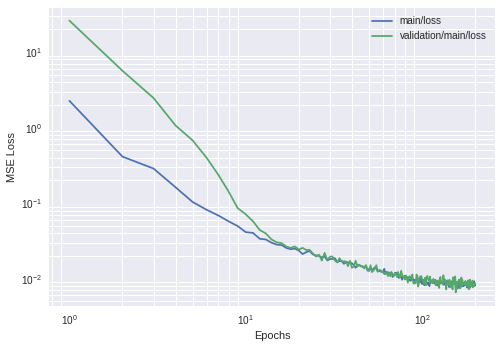

In [11]:
log_data = pd.read_json('sr_result/log')
plt.plot(log_data['epoch'],
         log_data['main/loss'], label='main/loss')
plt.plot(log_data['epoch'],
         log_data['validation/main/loss'], label='validation/main/loss')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid(which="both")
plt.ylabel('MSE Loss')
plt.xlabel('Epochs')
plt.show()

## Super-Resolution

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


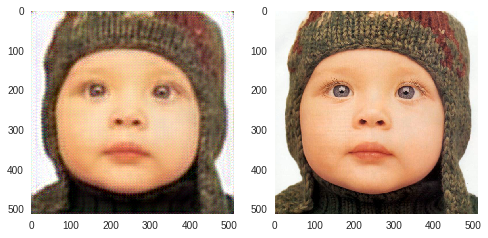

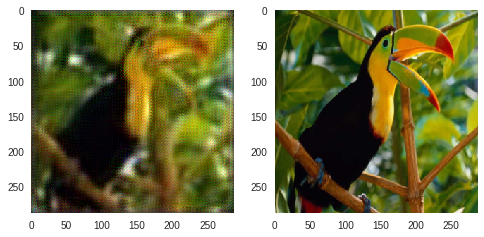

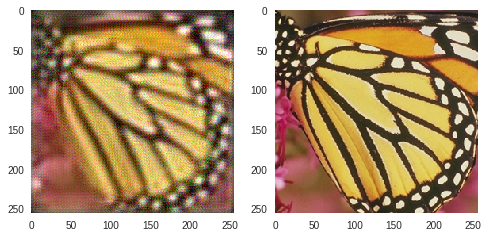

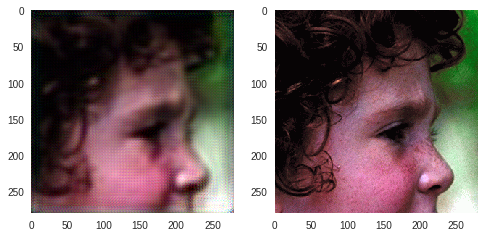

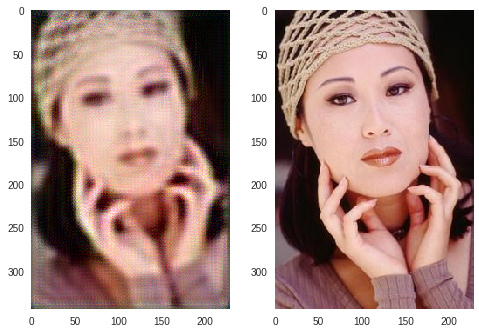

In [13]:
image_hr_paths = sorted(Path('Set5/HR').resolve().iterdir())
image_lr_paths = sorted(Path('Set5/LRx4').resolve().iterdir())

for hr_p, lr_p in zip(image_hr_paths, image_lr_paths):
    x_in = cp.array(Image.open(lr_p)) \
             .transpose(2, 0, 1)[cp.newaxis, :].astype(np.float32) / 255.
    x_out = model.enhance(x_in).array
    _, _, w, h = x_out.shape
    x_out = cp.asnumpy(x_out.reshape(3, w, h).transpose(1, 2, 0))
    x_out = cp.clip(x_out*255, 0, 255).astype(np.uint8)
    
    fig, (a1, a2) = plt.subplots(1, 2)
    Image.fromarray(x_out).save('SR_' + hr_p.name)
    a1.imshow(x_out)
    a1.grid(False)
    a2.imshow(Image.open(hr_p))
    a2.grid(False)
    fig.show()